# Movie Genre Classification with TF–IDF

In [1]:
from __future__ import annotations

from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


In [2]:
def load_movie_txt(txt_path):
    """Load the `id:::title:::genre:::description` text format safely."""
    txt_path = Path(txt_path)

    with txt_path.open('r', encoding='utf-8', errors='ignore') as f:
        raw = [ln.strip() for ln in f if ln.strip()]

    rows = []
    for ln in raw:
        parts = [p.strip() for p in ln.split(':::')]
        if len(parts) != 4:
            continue
        rows.append(parts)

    df_raw = pd.DataFrame(rows, columns=['id', 'title', 'genre', 'description'])

    # Clean id -> int
    df_raw['id'] = (
        df_raw['id']
        .astype(str)
        .str.replace(r'[^0-9]', '', regex=True)
        .replace('', np.nan)
        .astype('Int64')
    )

    # Normalize text fields
    for col in ['title', 'genre', 'description']:
        df_raw[col] = (
            df_raw[col]
            .astype(str)
            .str.strip()
            .str.replace(r'["“”]', '', regex=True)
        )

    # Keep only valid rows
    df_raw = df_raw.dropna(subset=['genre', 'description', 'title'])
    df_raw = df_raw.drop_duplicates(subset=['title', 'description'])

    return df_raw.reset_index(drop=True)


DATA_PATH = 'train_data.txt'  # update if needed
movies = load_movie_txt(DATA_PATH)
print('Rows after cleaning:', len(movies))
display(movies.head(3))


Rows after cleaning: 7935


,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...


Number of unique genres: 27
Genre examples: ['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family']


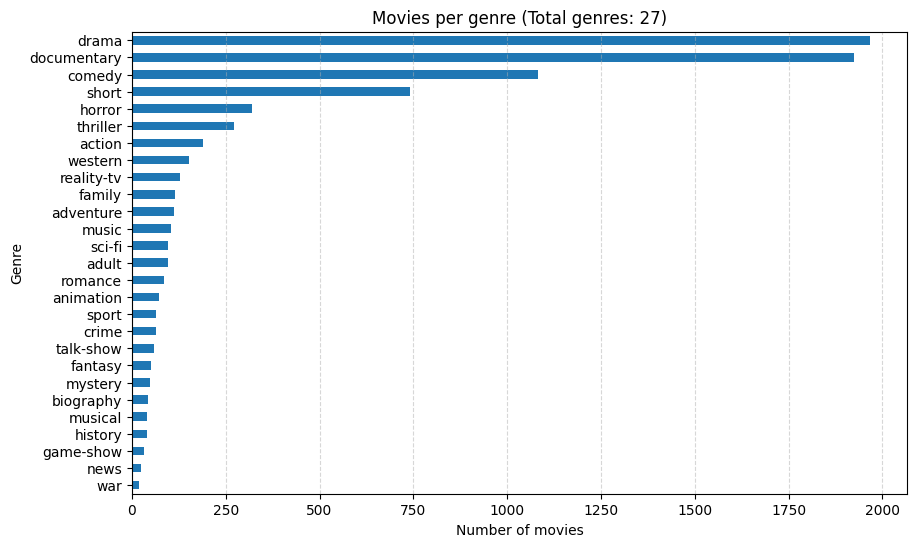

In [3]:
# Encode genre labels
le = LabelEncoder()
y = le.fit_transform(movies['genre'])

print('Number of unique genres:', len(le.classes_))
print('Genre examples:', list(le.classes_)[:10])

# Quick distribution plot (no seaborn)
counts = movies['genre'].value_counts().sort_values()
plt.figure(figsize=(10, 6))
counts.plot(kind='barh')
plt.xlabel('Number of movies')
plt.ylabel('Genre')
plt.title(f'Movies per genre (Total genres: {len(le.classes_)})')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


In [4]:
# Build features from descriptions (TF–IDF)
# Keeping the settings similar, but expressed through a Pipeline-friendly vectorizer.
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    min_df=2,
    stop_words='english',
    ngram_range=(1, 2),
)

X_desc = movies['description'].astype(str)
X_tfidf = vectorizer.fit_transform(X_desc)

print(f'TF–IDF matrix shape: {X_tfidf.shape} (rows x features)')


TF–IDF matrix shape: (7935, 44483) (rows x features)


In [6]:
# Show top correlated n-grams per genre via chi-square
TOP_K = 3
feature_names = np.array(vectorizer.get_feature_names_out())

for genre_name in le.classes_:
    gid = int(le.transform([genre_name])[0])
    chi2_scores, _ = chi2(X_tfidf, y == gid)
    best = np.argsort(chi2_scores)
    tokens = feature_names[best]

    uni = [t for t in tokens if len(t.split()) == 1]
    bi = [t for t in tokens if len(t.split()) == 2]

    print(f"==> {genre_name.upper()}")
    print('  • unigrams:', ', '.join(uni[-TOP_K:]))
    print('  • bigrams :', ', '.join(bi[-TOP_K:]))


==> ACTION
  • unigrams: raghuveer, ravi, martial
  • bigrams : game law, brock lesnar, martial arts
==> ADULT
  • unigrams: gagged, sex, anal
  • bigrams : gagged left, bound gagged, sexual adventures
==> ADVENTURE
  • unigrams: busty, bondage, gagged
  • bigrams : adventure travel, evil wizard, bound gagged
==> ANIMATION
  • unigrams: animated, doodle, bratz
  • bigrams : know story, animated feature, monster high
==> BIOGRAPHY
  • unigrams: cristo, ni, faked
  • bigrams : career spanned, single woman, life lillian
==> COMEDY
  • unigrams: comedic, hilarious, comedy
  • bigrams : comedy central, sketch comedy, comedy series
==> CRIME
  • unigrams: yokohama, yakuza, uwe
  • bigrams : meet man, criminal cases, local yakuza
==> DOCUMENTARY
  • unigrams: history, interviews, documentary
  • bigrams : length documentary, documentary follows, documentary film
==> DRAMA
  • unigrams: son, love, father
  • bigrams : based novel, young man, falls love
==> FAMILY
  • unigrams: zoo, riffic, pup

                   mean       std
model                            
LinearSVC      0.527662  0.006296
LogReg         0.486578  0.004584
MultinomialNB  0.437933  0.005216
RandForest     0.411216  0.001328


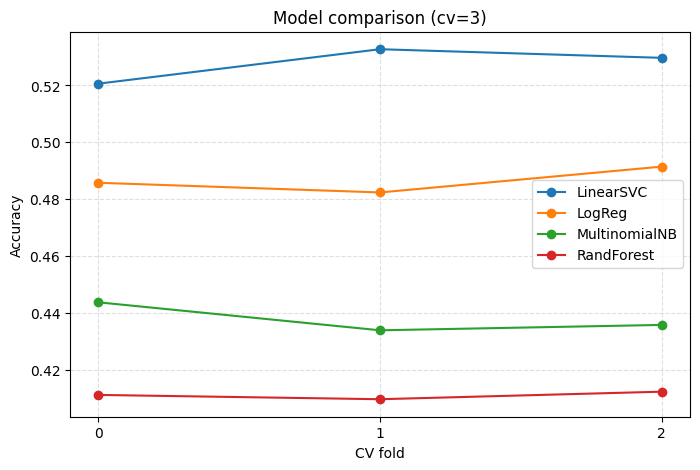

In [7]:
def compare_models(X_text, y_enc, cv=3, seed=42):
    """Compare a few classic text baselines using the same TF–IDF setup."""
    candidates = {
        'LinearSVC': LinearSVC(),
        'MultinomialNB': MultinomialNB(),
        'LogReg': LogisticRegression(max_iter=2000, random_state=seed),
        'RandForest': RandomForestClassifier(n_estimators=120, max_depth=6, random_state=seed),
    }

    rows = []
    for name, clf in candidates.items():
        pipe = Pipeline([
            ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=2, stop_words='english', ngram_range=(1, 2))),
            ('clf', clf),
        ])
        scores = cross_val_score(pipe, X_text, y_enc, scoring='accuracy', cv=cv)
        for i, s in enumerate(scores):
            rows.append({'model': name, 'fold': i, 'accuracy': float(s)})

    out = pd.DataFrame(rows)
    return out

cv_df = compare_models(movies['description'].astype(str), y, cv=3)
print(cv_df.groupby('model')['accuracy'].agg(['mean', 'std']).sort_values('mean', ascending=False))

# Simple visualization
plt.figure(figsize=(8, 5))
for name, grp in cv_df.groupby('model'):
    plt.plot(grp['fold'], grp['accuracy'], marker='o', label=name)
plt.xticks(sorted(cv_df['fold'].unique()))
plt.xlabel('CV fold')
plt.ylabel('Accuracy')
plt.title('Model comparison (cv=3)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      action       0.39      0.15      0.21        48
       adult       0.71      0.21      0.32        24
   adventure       0.50      0.14      0.22        28
   animation       1.00      0.06      0.11        18
   biography       0.00      0.00      0.00        11
      comedy       0.47      0.51      0.49       270
       crime       0.00      0.00      0.00        16
 documentary       0.61      0.86      0.72       481
       drama       0.49      0.68      0.57       492
      family       0.50      0.07      0.12        29
     fantasy       0.00      0.00      0.00        12
   game-show       1.00      0.38      0.55         8
     history       0.00      0.00      0.00        10
      horror       0.53      0.49      0.51        80
       music       0.78      0.27      0.40        26
     musical       0.00      0.00      0.00        10
     mystery       1.00      0.08      0.15        12
        news       0.00    

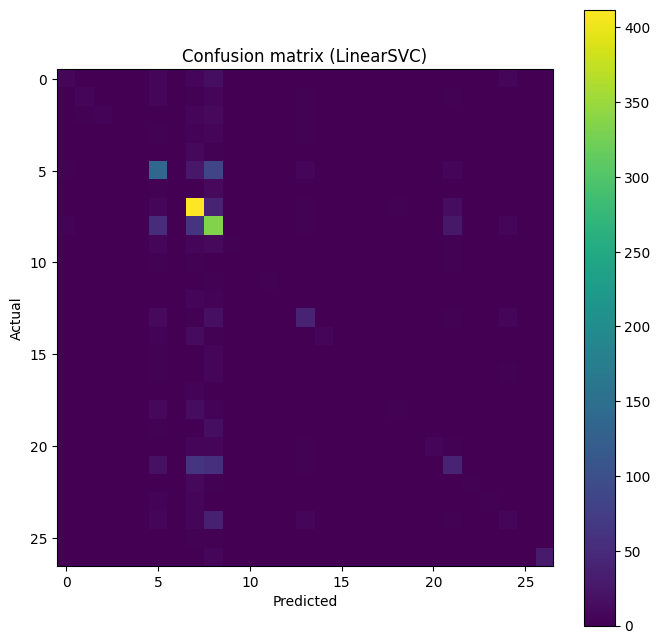

In [8]:
# Final train/test split + evaluation (TF–IDF on descriptions) using a single Pipeline
X_train, X_test, y_train, y_test = train_test_split(
    movies['description'].astype(str),
    y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

final_model = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=2, stop_words='english', ngram_range=(1, 2))),
    ('clf', LinearSVC()),
])

final_model.fit(X_train, y_train)
y_hat = final_model.predict(X_test)

print(classification_report(y_test, y_hat, target_names=le.classes_))

cm = confusion_matrix(y_test, y_hat)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix (LinearSVC)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()


In [9]:
# Inspect common confusions (>= 2 cases)
threshold = 2
for actual in range(cm.shape[0]):
    for predicted in range(cm.shape[1]):
        if actual == predicted:
            continue
        if cm[actual, predicted] >= threshold:
            print(f"{le.classes_[actual]} → {le.classes_[predicted]} : {cm[actual, predicted]} examples")


action → comedy : 8 examples
action → documentary : 5 examples
action → drama : 16 examples
action → thriller : 6 examples
adult → comedy : 6 examples
adult → documentary : 3 examples
adult → drama : 5 examples
adult → horror : 2 examples
adult → short : 3 examples
adventure → adult : 2 examples
adventure → documentary : 6 examples
adventure → drama : 10 examples
adventure → horror : 3 examples
animation → comedy : 3 examples
animation → documentary : 4 examples
animation → drama : 6 examples
animation → horror : 2 examples
biography → documentary : 9 examples
biography → drama : 2 examples
comedy → action : 3 examples
comedy → documentary : 26 examples
comedy → drama : 86 examples
comedy → horror : 6 examples
comedy → short : 8 examples
crime → comedy : 3 examples
crime → drama : 10 examples
documentary → comedy : 8 examples
documentary → drama : 40 examples
documentary → horror : 2 examples
documentary → reality-tv : 2 examples
documentary → short : 13 examples
drama → action : 4 exa

In [10]:
def predict_genre_from_description(description_text: str) -> str:
    """Predict a genre from a raw movie *description* string."""
    pred_id = int(final_model.predict([description_text])[0])
    return str(le.inverse_transform([pred_id])[0])

# Quick demo on a real row from the dataset
sample_description = movies.loc[0, 'description']
print('Sample description:', sample_description[:120], '...')
print('Predicted genre:', predict_genre_from_description(sample_description))


Sample description: Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to t ...
Predicted genre: drama
